# Keyword expansion 

In this exercise we are going to use the keyword expansion technique propsoed in `Computer-Assisted Keyword and Document Set Discovery from Unstructured Text` by King, Lam and Roberts (2017), in order to label a dataset of tweets according to whether or not they are related to covid-19. 

The idea is to use an initial list of keywords to label the date, and then use supervised learning to expand the list of keywords to get a better sense of how people talk about a topic. It is an iterative approach, meaning that you start with a list of keywords, and expand it, run it again etc. until you saturate the list. The approach also emphasises that you should read some of the text that you label, in order to ensure correct labelling. 


This exercise is a python translation of Gregory Eady's R exercise, heavily inspired by the replication material found here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/FMJDCD.

If interested, you can also see Greg's walk-through of the R version of this code in his video here: 
https://gregoryeady.com/SocialMediaDataCourse/readings/Keywords/

### Read in required packages 

In [1]:
import pandas as pd
#import pyreadr #package to allow us to read in .rds data files (native R datafile)
from nltk.stem.snowball import SnowballStemmer
import re
from tqdm import tqdm
from collections import OrderedDict
from collections import defaultdict
from collections import namedtuple
import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import random
from math import lgamma
from sklearn import linear_model
import matplotlib.pyplot as plt
import datetime

# 1. Load the data

Read in data as usual. 

In [2]:
# To read a .rds file

#result = pyreadr.read_r("MOC_Tweets.rds") 
#df = result[None] # extract the pandas data frame 


df = pd.read_csv('MOC_Tweets.csv')

# 1.1. Preprocessing 

Due to time restraints, the preprocessing code is given below, ready to be run. Take a look at the code to understand what is being done. 


Subset the data by removing tweets before 2019 (we are only interested in tweets that may reference COVID-19).

In [3]:
df = df[df.date  >= 20190101] # Subset to 2019 and later because we'll look at COVID-19 over time
df = df.loc[df.tweet_id.drop_duplicates().index] # removing duplicate observations (tweets)

In [4]:
df.reset_index(inplace = True, drop = True)

Save the original text and lowercase the text column.

In [5]:
df['text_original'] = df['text']
df['text'] = df['text'].str.lower()

Do some (but not all) preprocessing by removing tweet elements that we do not care about. 


In [6]:
# Remove mentions (posts that start with a "@some_user_name ")
df['text'] = df['text'].str.replace("\\B@\\w+|^@\\w+", "", regex = True)
# Change ampersands to "and"
df['text'] = df['text'].str.replace("&amp;", "and")
# Remove the "RT" and "via" (old retweet style)
df['text'] = df['text'].str.replace("(^RT|^via)((?:\\b\\W*@\\w+)+)","", regex=True, case=False)
# Remove URLs             
df['text'] = df['text'].str.replace("(https|http)?:\\/\\/(\\w|\\.|\\/|\\?|\\=|\\&|\\%)*\\b", "", regex = True)
# Keep ASCII only (removes Cyrillic, Japanese characters, etc.)
df['text'] = df['text'].str.replace("[^ -~]", "", regex = True)
# Remove double+ spaces (e.g. "build   the wall" to "build the wall")
df['text'] = df['text'].str.replace("\\s+", " ", regex = True)

With our mostly preprocessed tweets, let us begin building our classifier from chosen keywords. 

# 2. Define inclusion and exclusion keywords

You should now define the initial keywords that you want to include and exclude. Keywords to include should reference COVID-19, e.g. "covid19" and/or "coronavirus". We will use these initial keywords to find more keywords relevant to the topic.

1. Define 4 lists: the **first** should contain a seed reference word to be included, the **second** should contain the expanded list of reference words to include (empty to begin with), the **third** should contain a seed reference word to be excluded (can be left empty), and the **fourth** should contain the expanded list of reference words to exclude (empty to begin with). 

2. Using `.join`, collapse the two inclusion and exclusion lists, respectively, into strings that can be used as regex OR-operations. The result should be in the form \['dog', 'cat'\] --> 'dog|cat'

3. Use this regex string to create a bool column indicating whether the tweet contains one of your keywords.

4. If you have any exlusions, also find the tweets that contain the excluded keywords (the exclusion list can be left empty). 

5. Define a variable that is either 0 or 1, where 1 shows that the tweet contains one or more of your inclusion keywords _and_ does not contain any exclusion keywords. Create a bool column with this. 

6. See how many tweets you have labelled as related to COVID-19 so far (how many 0s and how many 1s). 

7. Sample 10 tweets labelled as COVID-19, and read the text in them (in the text_original column).

In [7]:
# The keywords that add through the keyword discovery process

reference_words_seed  = ["covid19"] #first word we started with

#reference_words_expanded = ["covid-19", "coronavirus"] #expanded list of keywords (just to show how it works)
reference_words_expanded = []

In [8]:
# The keywords that add through the keyword discovery process
reference_words_excluded = [] #initial
reference_words_excluded_expanded = [] #expanded


In [9]:
# Put the seed words and keywords added through discovery together

reference_words = reference_words_seed + reference_words_expanded
reference_words = "|".join(reference_words)

reference_words_excluded = reference_words_excluded + reference_words_excluded_expanded
reference_words_excluded = "|".join(reference_words_excluded)


In [10]:
reference_words

'covid19'

In [11]:
reference_words_excluded

''

In [12]:
# Will there be any keywords we want to exclude? this is simply a test 
excluded_words = len(reference_words_excluded.replace("|", "")) > 0 #checks if there are more chars than 0, returns a bool

print(excluded_words)

False


In [13]:
# Find tweets that contain any keywords that we want to include

df['includes'] = df['text'].str.contains(pat = reference_words, regex = True, case = False)


# Find tweets that contain any keywords that we want to exclude
df['excludes'] = False
if excluded_words:
    df['excludes']  = df.loc[df['text'].str.contains(pat = reference_words_excluded, regex = True, case = False),:]


In [14]:
# Just a bunch of TRUE and FALSE for the posts that include and exclude keywords
df['reference_set'] = (df['includes']== True) & (df['excludes'] == False) #all rows with the included and without the excluded
df['reference_set'] = df['reference_set'] *1 #make into numeric


In [15]:
#how many of each?
df['reference_set'].value_counts()


0    579403
1       417
Name: reference_set, dtype: int64

These are the tweets we have labelled to be about covid-19. Now let us sample some of them. 

In [16]:
samp = df.loc[df['reference_set']==1,'text_original'].sample(5)

In [17]:
for i in samp:
    print("Tweet:",i)

Tweet: The greatest risk for #COVID19 infection is among those who are in close contact with people who have COVID-19. Thi… https://t.co/oXeXLb7QAG
Tweet: Want to help prevent the spread of #COVID19? Here’s what the CDC suggests: -Avoid close contact w/ people who are s… https://t.co/gRTu5lIjDE
Tweet: Follow @OHdeptofhealth for all #COVID19 updates.  ⬇️⬇️⬇️⬇️⬇️ https://t.co/qFR9zRJP8I
Tweet: Current understanding is #COVID19 spreads mostly from person to person through respiratory droplets produced when a… https://t.co/hAP89WxLFX
Tweet: .@repgregwalden says we have an "all-government approach" to contain #COVID19, support communities and local public… https://t.co/pNEHC0oDOb


# 3. Further preprocessing and vectorizing

Next, we need to tokenize the data and preprocess the tokens (as opposed to the preprossesing on the full string as earlier). 

We will also remove all the keywords that demarcate exclusion and inclusion from the covid-19 theme. This is becasue we want the model to learn to predict the topic using other, new keywords. 

1. Create a new col named "text_preprocessed" - it should be equal the text col, but with the keywords removed (Hint: use `.str.replace()` with `regex = True`). 

----- 

To spend less time on lessons you have already been through, code for further preprocessing is provided. This code may take a few minutes to run. The steps are: 

2. Tokenizing. A whitespace tokenizer is used, since we want to keep words with '-'.

3. Removing any tokens that are only numbers (you can remove more types of tokens if you want - up to you).

4. Remove any empty strings.

5. Stemming.

6. Re-joining the stemmed tokens using a whitespace.

7. Creating a column with the preprocessed sentences.

----- 

8. Now you have a column  of sentences made out of stemmed and preprocessed tokens. Use a CountVectorizer to make a document term matrix based on this column. Set `min_df = 10` and `max_df = 0.999`, as well as `stop_words = 'english'` and set an appropriate `ngram_range`. 

NB: Do not try to make this DTM into a dataframe or np array, as you will most likely run out of memory. It is a sparse matrix that you can work with in the same way as an np.array.



In [18]:
# We'll remove the keywords from the tweets so that the machine learning model
# needs to use the words in each tweet that aren't those keywords to predict
# whether it belongs in the target set or not the target set

remove_keywords_from_tweets = True

#make a reg-ex list of all the inclusion and exclusion words

if excluded_words: #if there are exclusion words
    all_current_keywords = reference_words + "|" + reference_words_excluded
else:
    all_current_keywords = reference_words


df['text_preprossed'] = df['text']

if remove_keywords_from_tweets:
    df['text_preprossed'] = df['text'].str.replace(all_current_keywords, "", regex = True, case = False)


In [19]:
tokenizer = WhitespaceTokenizer()
ps = PorterStemmer()

In [20]:
pre_prossed_sents =[]
for sent in tqdm(df['text_preprossed']):
    words = tokenizer.tokenize(sent)
    words = [re.sub(r'\d+', '', word) for word in words] #removing tokens that are only words 
    words = [x for x in words if x] #removing empty strings
    sent_stem = [ps.stem(word) for word in words]
    
    sent_done = " ".join(sent_stem)
    pre_prossed_sents.append(sent_done)


100%|██████████| 579820/579820 [03:16<00:00, 2948.00it/s]


In [21]:
df['text_pre_stem'] = pre_prossed_sents

In [22]:
# Consider saving a csv at this time

#df.to_csv('MOC_Tweets_preprocessed.csv')

In [23]:
vectorizer = CountVectorizer(min_df = 10,
                           max_df = 0.999,
                           stop_words='english',
                          ngram_range = (1,2)) #set for larger n-grams

corpus = vectorizer.fit_transform(df['text_pre_stem'])

In [24]:
DTM_dict = {"DTM":corpus,
               "labels":list(df['reference_set'])} 

# 4. Sample training data and make predictions

Let us sample some tweets we will use to train our classifier. 

1) Define two lists of indices: One list containing the indices of the tweets in the reference set (those labelled as belonging to the covid-19 topic), and another list containing N sample of tweets not from the reference set (N should be either 2x the amount of tweets in the reference set or 50000, whichever is smaller).

2) You now have 2 lists of indices – use these to subset the Document Term Matrix (where each row represents a tweet, and each column a token) and the reference set column in the dataframe (the labels). Define a train DTM and  a train labels object. 

3) Fit a cross validated lasso regression, using the DTM subset as input (X) and the reference subset as labels (y). This means that we are trying to predict whether a tweet is in the reference set using the term frequencies. (Hint:  use sklearn's `linear_model.LasssoCV()`). This may take some time (approx. 5 min, depending on the size of your train data).

4) Use the fitted model to make predictions on the full DTM, and create a column in the dataframe called `predicted_raw` based on this. (Remember that the rows in the DTM correspond to the rows in the dataframe).

5) The prediction outputs propabilities and not classes, so check the standard deviation of the predicion_raw column - this will check if we actually have some variance in the prediction. This is just a sanity check.

6) Set a threshold of 0.25, and assign 1 or 0 to a new column called `predicted`, depending on whether the probability in `predicted_raw` is >= the threshold. (Note: Keep the threshold low if you want more tweets to get into the target set).

7) Create a column called `set_var`. This variable should be == "Reference" if the observation is in the reference set (our original covid-19 labels), "Target" if it is _predicted_ to be a covid-19 related tweet (1) and "Not target" if it is _predicted_ not to be (0).

8) Create a crosstable of the prediciton and set_var, to see how you model does (hint: use use `pd.crosstab()`). Examine the crosstab - what do the different entries mean? 

In [25]:
# Determine how many tweets to sample for the training data

n_search = min(sum(df['reference_set']==1)* 2, 50000)

#NB: Greg uses *20 - but that would take too long to run for the purposes of this exercise


In [26]:
# Create lists of indices, indicating which belong to the reference set (those labelled to be about covid)
#   and which do not belong to the reference set

reference_ids = list(df[df['reference_set']==1].index)
search_ids = list(df[df['reference_set']==0].index)

In [27]:
# Taking a random sample of the search indices, i.e. those that do not belong to the reference set
search_ids_sample = random.choices(search_ids, k=n_search)
ids = reference_ids + search_ids_sample # putting them together to create the full list of training set indices

# Checking amounts
print(len(reference_ids),len(search_ids_sample),len(ids))

417 834 1251


In [28]:
# Saving the training data in a dict object
DTM_train = {"DTM" : corpus[ids,:],
            "labels": list(df['reference_set'][ids])}

In [29]:
# Defining the classifier

#linear lasso
#clf = linear_model.LassoCV(n_jobs=-1, verbose=1) #this was a mistake - should be log reg - small mistake though

#logistic reg with lasso penalty - this will actually give probs! e
clf = linear_model.LogisticRegressionCV(penalty="l1", n_jobs = -1, solver = "saga", max_iter=10000, verbose = 1)

In [30]:
# Fitting the model. This takes some time. 

clf.fit(DTM_train['DTM'], DTM_train['labels']) 

convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 262 epochs took 0 seconds
convergence after 302 epochs took 0 seconds
convergence after 271 epochs took 0 seconds
convergence after 274 epochs took 0 seconds
convergence after 288 epochs took 0 seconds
convergence after 193 epochs took 1 seconds
convergence after 218 epochs took 1 seconds
convergence after 263 epochs took 1 seconds
convergence after 244 epochs took 1 seconds
convergence after 259 epochs took 1 seconds
convergence after 1841 epochs took 6 seconds
convergence after 2106 epochs took 7 seconds
convergence after 2195 epochs took 7 seconds
convergence after 2260 epochs took 7 seconds
convergence after 2089 epochs took 8 seconds
convergence after 1025 epochs took 5 seconds
convergence after 1023 epochs took 6 seconds
convergence after 1608 epochs took 7 seconds
convergence after 1425 epochs took 7 seconds
convergence after 1871 epochs took 9 seconds
convergence after 411 epochs took 4 seconds
convergence after 527 epochs took 6 seconds
convergence after 687 

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished


LogisticRegressionCV(max_iter=10000, n_jobs=-1, penalty='l1', solver='saga',
                     verbose=1)

In [31]:
# Making predictions on the full dataset

predictions = clf.predict(corpus)

In [32]:
# Check if all predictions are the same (we don't want this to be zero)
# If so, there is a problem: potentially too few observations in the reference
# set relative to the search set

np.std(predictions)

0.2150656125324694

In [33]:
# Set a threshold

threshold = 0.25


In [34]:
# Saving variables so far in a dict

DTM_full = {'DTM':corpus,
            'raw_preds': predictions,
            'preds': (predictions > threshold) * 1 ,
            'reference': list(df['reference_set']==1),
            'reference_ids': reference_ids}

In [35]:
# Predict whether each tweet is in the reference set based on a predicted
# probability, where Pr(reference_set = 1) > threshold. Keep this low if want
# more tweets to get into the target set

In [36]:
set_var = []

for i in range(0,len(DTM_full['preds'])):
    if i in reference_ids: #if the obs is in the reference group
        set_var.append('Reference')
    
    elif DTM_full['preds'][i] == 1:
        set_var.append('Target')
    
    elif DTM_full['preds'][i] == 0:
        set_var.append('Not target')
    
    else:
        set_var.append(None)
        

In [37]:
# Creating a new dataframe of predictions 

pred_df = pd.DataFrame([pd.Series(DTM_full['preds']),pd.Series(set_var)]).T

In [38]:
# Checking performance (only classification of the reference observations are relevant to check)

pd.crosstab(pred_df[0],pred_df[1])


1,Not target,Reference,Target
0,,,
0,551631,0,0
1,0,417,27772


In [39]:
# Saving the Reference/Target/Not target in the dict 

DTM_full['set_var'] = set_var

# 5. Calculate the log likelihood as in the paper

1) Create 3 sets of indices based on the `set_var` colum: one for "Target", one for "Not target" and one for "Reference". 

2) Create 3 objects for the target, not_target and reference sets, based on the DTM. These should be: for each token, how often is the given token in the set, how many documents in the set contains the given token, and the proportion of documents in the set containing the given token. (Hint: see sample code for the target set. If you want to convert to a list and not a matrix object, you can use the `.tolist()[0]`)

3) Create a new dataframe, where each row is a token from the DTM (you can use `vectorizer.get_feature_names()`), with 9 cols for each of the 9 objects you just created. 

4) Subset the dataset by removing any observations where the terms do not appear in either the target or not_target set, thus keeping only tokens that were in the original search set (step (a) on page 979).

5) Keywords go in the target list if their proportion is higher among those documents estimated to be in the reference set than not; e.g. if for the word "pandemic", 15% of documents predicted as target contain the word "pandemic" versus only 2% among those in the not_target set (step (b) on page 979). Therefore: create a new column that should be True if the token has a higher or equal proportion in the target set than in the not_target set. 

6) Examine the `llik` function provide and look in the paper - what does it do? 

7) Calculate the amount of documents in the target and the not_target set.

8) Use the provided function to calculate the log likelihood for each token. Assign this to a new column in the dataframe created in step 3. 


In [40]:
# Creating 3 lists of indices

target_ids = list(pd.Series(DTM_full['set_var']) == 'Target')
not_target_ids = list(pd.Series(DTM_full['set_var']) == 'Not target')
ref_ids = list(pd.Series(DTM_full['set_var']) == 'Reference')

In [41]:
# Creating statistics for the target, not_target and reference sets 

target_freq = np.sum(DTM_full['DTM'][target_ids,:],0) #how many times is each token used in the target documents
target_num_docs = np.sum(DTM_full['DTM'][target_ids,:] > 0, axis = 0) #how many target documents does each token appear in
target_num_docs_prop =  target_num_docs / sum(target_ids) #proportion of target docs with each token


not_target_freq = np.sum(DTM_full['DTM'][not_target_ids,:],0) #how many times is each token used in the not_target documents
not_target_num_docs = np.sum(DTM_full['DTM'][not_target_ids,:]> 0,axis = 0) #how many not_target documents does each token appear in
not_target_num_docs_prop =  not_target_num_docs / sum(not_target_ids) #proportion of not_target docs with each token


ref_freq = np.sum(DTM_full['DTM'][ref_ids,:],0) #how many times is each token used in the reference documents
ref_num_docs = np.sum(DTM_full['DTM'][ref_ids,:] > 0, axis = 0) #how many reference documents does each token appear in
ref_num_docs_prop =  ref_num_docs / sum(ref_ids) #proportion of reference docs with each token


# Saving the above in a dict 

d = {'target_freq' :target_freq.tolist()[0],
    'target_num_docs': target_num_docs.tolist()[0],
    'target_num_docs_prop': target_num_docs_prop.tolist()[0],
    'not_target_freq':not_target_freq.tolist()[0],
    'not_target_num_docs': not_target_num_docs.tolist()[0],
    'not_target_num_docs_prop': not_target_num_docs_prop.tolist()[0],
    'ref_freq':ref_freq.tolist()[0],
    'ref_num_docs': ref_num_docs.tolist()[0],
    'ref_num_docs_prop': ref_num_docs_prop.tolist()[0]}


In [43]:
# Creating a dataframe based on the dict and token names

df_prop = pd.DataFrame(d, index=vectorizer.get_feature_names_out())

In [44]:
# Subsetting observations that are target or not target at least once (probably all)
df_prop = df_prop.loc[(df_prop['target_freq']> 0) | (df_prop['not_target_freq'] > 0), :]

In [45]:
# Creating a column that is True if the token has a higher or equal proportion in the target set than in the not_target set. 
df_prop['target_larger'] = df_prop['target_num_docs_prop'] >= df_prop['not_target_num_docs_prop']


In [46]:
# Taking a look at our new dataframe
df_prop

,target_freq,target_num_docs,target_num_docs_prop,not_target_freq,not_target_num_docs,not_target_num_docs_prop,ref_freq,ref_num_docs,ref_num_docs_prop,target_larger
__,0,0,0.000000,27,21,0.000038,0,0,0.0,False
aa,2,2,0.000072,17,16,0.000029,0,0,0.0,True
aandm,2,2,0.000072,49,49,0.000089,0,0,0.0,False
aandt,1,1,0.000036,10,10,0.000018,0,0,0.0,True
aapi,10,8,0.000288,256,226,0.000410,0,0,0.0,False
...,...,...,...,...,...,...,...,...,...,...
zte,4,3,0.000108,37,37,0.000067,0,0,0.0,True
zuck,0,0,0.000000,11,10,0.000018,0,0,0.0,False
zuckerberg,32,32,0.001152,152,145,0.000263,0,0,0.0,True
zuckerberg facebook,0,0,0.000000,13,13,0.000024,0,0,0.0,False


In [47]:
# Likelihood function

def llik(target_num_docs, nottarget_num_docs, target_num_docs_total, nottarget_num_docs_total):
    '''No docstring - you neew to see what it does :) '''
    x1 = ((lgamma(target_num_docs + 1) + lgamma(nottarget_num_docs + 1)) -
           lgamma(target_num_docs + nottarget_num_docs + 1 + 1))
    x2 = ((lgamma(target_num_docs_total - target_num_docs + 1) +
           lgamma(nottarget_num_docs_total - nottarget_num_docs + 1)) -
           lgamma(target_num_docs_total - target_num_docs +
          nottarget_num_docs_total - nottarget_num_docs + 1 + 1))
    llik = x1 + x2
    return llik

In [48]:
# Finding the total number of documents in the target and not_target sets 

target_num_docs_total = sum(target_ids)
nottarget_num_docs_total =  sum(not_target_ids) 

In [49]:
# Calculating the likelihood for each token

llik_list= []
for i in range(len(df_prop)):
    t =df_prop['target_num_docs'][i]
    nt =df_prop['not_target_num_docs'][i]
    l = llik(t,nt,target_num_docs_total,nottarget_num_docs_total)
    llik_list.append(l)


In [50]:
# Saving the likelihood scores 

df_prop['llik'] = llik_list


# 6. Examine new keywords

1) Show the top 25 keywords based on highest log likelihood, where the share of documents in the target set is higher than in the not_target set (see task 5.5). These are the tokens that are most likely to differentiate between the target and not_target sets (meaning that they help the model predict covid-19 related tweets).

2) Do the same with the not_target - what are these terms representative of? 

3) Are there any of these tokens that you want to include in the keywords? Choose 1-3 keywords that you want to include or exclude. 

4) For the 1-3 keywords you have found, find tweets that contain the given keyword in the original tweet text in the original dataframe. Read some tweets where the keyword is used in context - do you still want to include or exclude the keyword? 

5) Optional: add the new keywords to the original list at the beginning of this exercise in 2.1, and rerun the exercises until here, now including the new keywords. This is how the computer-assisted keyword discovery is used iteratively. 


In [51]:
df_prop.loc[df_prop['target_larger'] == True].sort_values('llik',ascending = False).head(25)

,target_freq,target_num_docs,target_num_docs_prop,not_target_freq,not_target_num_docs,not_target_num_docs_prop,ref_freq,ref_num_docs,ref_num_docs_prop,target_larger,llik
inform,3433,3287,0.118357,1622,1616,0.002929,33,33,0.079137,True,-104335.950823
respons,3295,3199,0.115188,2874,2866,0.005196,33,31,0.074341,True,-105645.649811
coronaviru,1702,1696,0.061069,19,19,0.000034,40,40,0.095923,True,-106379.146232
respond,2086,1986,0.071511,1587,1576,0.002857,18,18,0.043165,True,-107747.652128
spread,1232,1217,0.043821,399,398,0.000721,84,84,0.201439,True,-108637.000908
case,1754,1643,0.059160,2728,2693,0.004882,41,40,0.095923,True,-109190.803776
monitor,882,859,0.030930,236,232,0.000421,17,17,0.040767,True,-109407.840931
coronavirus,716,716,0.025781,63,63,0.000114,22,22,0.052758,True,-109508.747058
public health,1115,1080,0.038888,987,978,0.001773,15,15,0.035971,True,-109553.321815
emerg,1607,1491,0.053687,2980,2841,0.005150,30,29,0.069544,True,-109565.112853


In [52]:
df_prop.loc[df_prop['target_larger'] == False].sort_values('llik',ascending = False).head(25)

,target_freq,target_num_docs,target_num_docs_prop,not_target_freq,not_target_num_docs,not_target_num_docs_prop,ref_freq,ref_num_docs,ref_num_docs_prop,target_larger,llik
rt,434,434,0.015627,64173,63998,0.116016,3,3,0.007194,False,-109475.916093
wa,475,461,0.016599,49248,44062,0.079876,8,8,0.019185,False,-110424.500543
trump,474,468,0.016852,46651,43116,0.078161,2,2,0.004796,False,-110475.008986
presid,386,378,0.013611,39376,36278,0.065765,0,0,0.000000,False,-110616.981515
honor,43,43,0.001548,21234,20348,0.036887,0,0,0.000000,False,-110641.241836
year,344,337,0.012135,33712,31645,0.057366,0,0,0.000000,False,-110742.917484
great,240,238,0.008570,28695,27395,0.049662,0,0,0.000000,False,-110756.560849
day,316,308,0.011090,29298,27101,0.049129,2,2,0.004796,False,-110881.698018
american,965,946,0.034063,49308,45944,0.083288,6,6,0.014388,False,-110943.619346
nation,552,544,0.019588,35542,33288,0.060345,1,1,0.002398,False,-110955.286783


In [57]:

def see_in_context(term):
    '''Gets the tweets orginial text with the term - also supports regex - seachers the full tect
    only returns tweets not in the orginial reference list'''
    if vectorizer.get_feature_names_out().any():
        subset = df.loc[(df['text_original'].str.contains(pat = term,regex = True, case = False)) & (df['reference_set'] == False),'text_original']
        if len(subset) != 0:
            return subset
        else:
            print("This is not a term in the corpus")

    else:
        print("This is not a term in the corpus")



In [58]:
see_in_context("respons")

202       .@AmericanLegion rightfully prides itself on b...
458       Stemming the #opioidcrisis tide requires enfor...
491       One of the federal government's most fundament...
510       Recovering from a disaster takes time &amp; re...
722       Watch: @SenJohnHoeven and I discuss why servin...
                                ...                        
578828    The safety of Americans at home and abroad is ...
578976    We have a moral responsibility to future gener...
579060    RT @RepKinzinger: Dear Left: There won’t be an...
579067    Yesterday, @VP Pence spoke to us about the adm...
579620    I’m disappointed to learn of the layoffs in Sl...
Name: text_original, Length: 7876, dtype: object

# 7. Optional: Use your new classifier for downstream tasks

1) Assign a `final_classification` boolean column in the original dataframe, which should be 1 if the tweet contains any of the keywords in the new, complete list and if it does not contain any of the exclusion keywords. 

2) Examine the value counts of the political affiliation variable. Assign "Democrat" to the tweets labelled with "Independent" (see the people behind the tweets for reason).

3) Plot the share of tweets labelled as covid-19 relevant by your classifier (y), grouped on days (x) for each party - meaning two lines of covid-19 share across time. 

**Hints:** <br>
The pandas `groupby` functionality may be of help to you. <br>
You can also also turn the date ints into so-called datetime objects using this:

`dates =[datetime.datetime(year=int(x[i][0:4]), month=int(x[i][4:6]), day=int(x[i][6:8])) for i in range(len(x))]`

where x is a list of the unique dates as int. 


In [59]:
# We saved no exclusion keywords so far, so this is just a look up of the terms in the preprocessed dataset

df['final_calssification'] = df['text'].str.contains(pat = reference_words, regex = True, case = False)


In [60]:
# Checking political affiliations of tweeters

df.affiliation.value_counts()

Democrat       369593
Republican     208158
Independent      2069
Name: affiliation, dtype: int64

In [61]:
# Changing the independents to democrats 

df.loc[df['affiliation'] == "Independent",'affiliation'] = "Democrat" #the only independets are dems


In [62]:
# Checking that it worked

df.affiliation.value_counts()

Democrat      371662
Republican    208158
Name: affiliation, dtype: int64

In [63]:
plt_df = df.loc[(df['date'] > 20200101) & (df['date'] < 20200307)] #remove last day as it seems to have fewer tweets


In [64]:
# Grouping by affiliation and date to create y values

y_dem_freq_cov = list(plt_df.loc[df['affiliation'] == 'Democrat',:].groupby(['date']).sum().iloc[:,-1])
y_dem_freq_total = list(plt_df.loc[df['affiliation'] == 'Democrat',:].groupby(['date']).count().iloc[:,-1])

y_dem = [i / j for i, j in zip(y_dem_freq_cov,  y_dem_freq_total)]

y_rep_freq_cov = list(plt_df.loc[df['affiliation'] == 'Republican',:].groupby(['date']).sum().iloc[:,-1])
y_rep_freq_total = list(plt_df.loc[df['affiliation'] == 'Republican',:].groupby(['date']).count().iloc[:,-1])

y_rep = [i / j for i, j in zip(y_rep_freq_cov,  y_rep_freq_total)]

C:\Users\chris\AppData\Local\Temp\ipykernel_3548\4169470675.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_dem_freq_cov = list(plt_df.loc[df['affiliation'] == 'Democrat',:].groupby(['date']).sum().iloc[:,-1])
C:\Users\chris\AppData\Local\Temp\ipykernel_3548\4169470675.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  y_rep_freq_cov = list(plt_df.loc[df['affiliation'] == 'Republican',:].groupby(['date']).sum().iloc[:,-1])


In [65]:
# x is the dates
x = np.sort(plt_df.date.unique()).astype(int).astype(str)


In [66]:
dates =[datetime.datetime(year=int(x[i][0:4]), month=int(x[i][4:6]), day=int(x[i][6:8])) for i in range(len(x))]

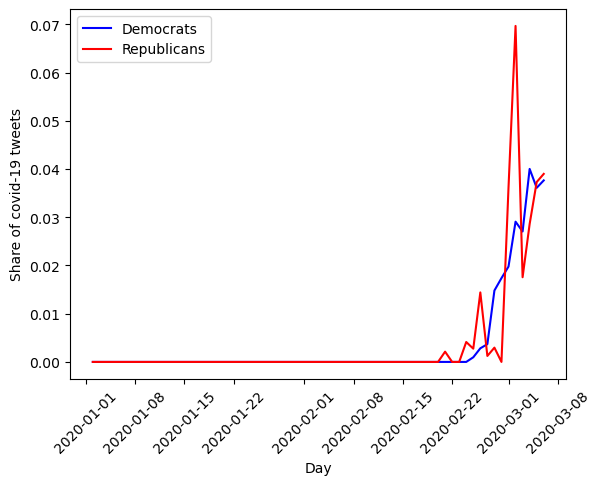

In [67]:
# Plotting the distribution of tweeting about covid-19 across democrats and republicans

plt.plot(dates,y_dem, label = "Democrats", color = "Blue")
plt.plot(dates,y_rep, label = "Republicans", color = "Red")

plt.ylabel("Share of covid-19 tweets")
plt.xlabel('Day')
plt.xticks(rotation=45)

plt.legend()
plt.show()
